# 사전작업

## 라이브러리 로드

In [1]:
import numpy as np
import pandas as pd
import warnings
import gc
from tqdm import tqdm_notebook
import lightgbm as lgb
from scipy.sparse import vstack, csr_matrix, save_npz, load_npz
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")
gc.enable()
# sns.set()

In [2]:
pd.set_option('max_rows', 150)
pd.set_option('max_colwidth', 500)
pd.set_option('max_columns', 500)

In [3]:
dtypes = {
        'MachineIdentifier':                                    'object',
        'ProductName':                                          'category',
        'EngineVersion':                                        'category',
        'AppVersion':                                           'category',
        'AvSigVersion':                                         'category',
        'IsBeta':                                               'int8',
        'RtpStateBitfield':                                     'float16',
        'IsSxsPassiveMode':                                     'int8',
        'DefaultBrowsersIdentifier':                            'float16',
        'AVProductStatesIdentifier':                            'float32',
        'AVProductsInstalled':                                  'float16',
        'AVProductsEnabled':                                    'float16',
        'HasTpm':                                               'int8',
        'CountryIdentifier':                                    'int16',
        'CityIdentifier':                                       'float32',
        'OrganizationIdentifier':                               'float16',
        'GeoNameIdentifier':                                    'float16',
        'LocaleEnglishNameIdentifier':                          'int8',
        'Platform':                                             'category',
        'Processor':                                            'category',
        'OsVer':                                                'category',
        'OsBuild':                                              'int16',
        'OsSuite':                                              'int16',
        'OsPlatformSubRelease':                                 'category',
        'OsBuildLab':                                           'category',
        'SkuEdition':                                           'category',
        'IsProtected':                                          'float16',
        'AutoSampleOptIn':                                      'int8',
        'PuaMode':                                              'category',
        'SMode':                                                'float16',
        'IeVerIdentifier':                                      'float16',
        'SmartScreen':                                          'category',
        'Firewall':                                             'float16',
        'UacLuaenable':                                         'float32',
        'Census_MDC2FormFactor':                                'category',
        'Census_DeviceFamily':                                  'category',
        'Census_OEMNameIdentifier':                             'float16',
        'Census_OEMModelIdentifier':                            'float32',
        'Census_ProcessorCoreCount':                            'float16',
        'Census_ProcessorManufacturerIdentifier':               'float16',
        'Census_ProcessorModelIdentifier':                      'float16',
        'Census_ProcessorClass':                                'category',
        'Census_PrimaryDiskTotalCapacity':                      'float32',
        'Census_PrimaryDiskTypeName':                           'category',
        'Census_SystemVolumeTotalCapacity':                     'float32',
        'Census_HasOpticalDiskDrive':                           'int8',
        'Census_TotalPhysicalRAM':                              'float32',
        'Census_ChassisTypeName':                               'category',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float16',
        'Census_InternalPrimaryDisplayResolutionHorizontal':    'float16',
        'Census_InternalPrimaryDisplayResolutionVertical':      'float16',
        'Census_PowerPlatformRoleName':                         'category',
        'Census_InternalBatteryType':                           'category',
        'Census_InternalBatteryNumberOfCharges':                'float32',
        'Census_OSVersion':                                     'category',
        'Census_OSArchitecture':                                'category',
        'Census_OSBranch':                                      'category',
        'Census_OSBuildNumber':                                 'int16',
        'Census_OSBuildRevision':                               'int32',
        'Census_OSEdition':                                     'category',
        'Census_OSSkuName':                                     'category',
        'Census_OSInstallTypeName':                             'category',
        'Census_OSInstallLanguageIdentifier':                   'float16',
        'Census_OSUILocaleIdentifier':                          'int16',
        'Census_OSWUAutoUpdateOptionsName':                     'category',
        'Census_IsPortableOperatingSystem':                     'int8',
        'Census_GenuineStateName':                              'category',
        'Census_ActivationChannel':                             'category',
        'Census_IsFlightingInternal':                           'float16',
        'Census_IsFlightsDisabled':                             'float16',
        'Census_FlightRing':                                    'category',
        'Census_ThresholdOptIn':                                'float16',
        'Census_FirmwareManufacturerIdentifier':                'float16',
        'Census_FirmwareVersionIdentifier':                     'float32',
        'Census_IsSecureBootEnabled':                           'int8',
        'Census_IsWIMBootEnabled':                              'float16',
        'Census_IsVirtualDevice':                               'float16',
        'Census_IsTouchEnabled':                                'int8',
        'Census_IsPenCapable':                                  'int8',
        'Census_IsAlwaysOnAlwaysConnectedCapable':              'float16',
        'Wdft_IsGamer':                                         'float16',
        'Wdft_RegionIdentifier':                                'float16',
        'HasDetections':                                        'int8'
        }

## 데이터 로드

In [4]:
%%time
train = pd.read_csv('./data/train.csv', dtype=dtypes)
test = pd.read_csv('./data/test.csv', dtype=dtypes)

Wall time: 3min 33s


## train, test 합치기

In [5]:
test['HasDetections'] = np.nan
data = train.append(test)
data.reset_index(drop=True, inplace=True)
data = data.reset_index().drop(['MachineIdentifier'], axis=1).rename(columns={'index':'MachineIdentifier'})
del train, test
gc.collect()

194747

## Get Date - AvSigVersion

In [6]:
datedict = np.load('./data/AvSigVersionTimestamps.npy')
datedict = datedict[()]
data['Date'] = data['AvSigVersion'].map(datedict)
data['Date_YMD'] = pd.to_datetime(data['Date'].astype(str).str.slice(0, 10))
del datedict

In [121]:
temp = pd.DataFrame(time_idx)

In [122]:
tr_temp = train.groupby('Date_YMD').HasDetections.agg(['size', 'mean']).reset_index()
te_temp = test.groupby('Date_YMD').HasDetections.agg(['size', 'mean']).reset_index()

In [123]:
tr_temp = temp.merge(tr_temp, on='Date_YMD', how='left')#.fillna(0)
te_temp = temp.merge(te_temp, on='Date_YMD', how='left')#.fillna(0)

In [124]:
condition = (tr_temp.Date_YMD >= '2018-07-01')&(tr_temp.Date_YMD <= '2018-08-01')
tr_temp = tr_temp[condition]
te_temp = te_temp[condition]

In [69]:
tr_temp = tr_temp[tr_temp['size'] > 20000]
te_temp = te_temp[te_temp['size'] > 20000]

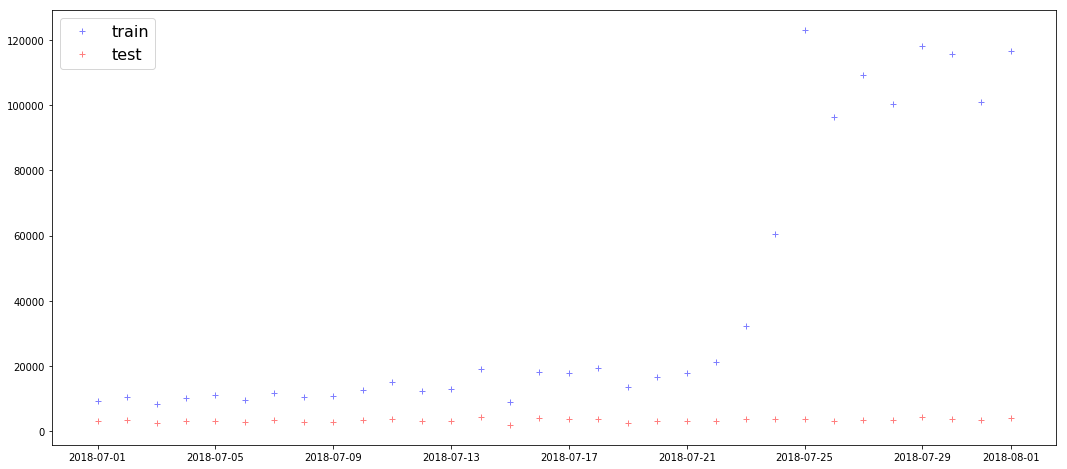

In [125]:
plt.figure(figsize=(18, 8))
plt.plot(tr_temp.Date_YMD, tr_temp['size'], '+', color='b', alpha=0.5, label='train')
plt.plot(te_temp.Date_YMD, te_temp['size'], '+', color='r', alpha=0.5, label='test')
plt.legend(('train', 'test'), prop={'size': 16})

In [115]:
tr_temp[tr_temp['size'] > 40000]

,Date_YMD,size,mean
841,2018-03-01,99606.0,0.465946


In [116]:
te_temp[te_temp['size'] > 40000]

,Date_YMD,size,mean
841,2018-03-01,133384.0,NaN


In [120]:
tr_temp

,Date_YMD,size,mean
0,2013-07-18,10.0,0.600000
1,2014-02-21,3.0,0.333333
2,2014-03-18,4.0,0.500000
3,2014-04-03,1.0,1.000000
4,2014-04-12,NaN,NaN
5,2014-06-19,1.0,1.000000
6,2014-10-23,NaN,NaN
7,2014-11-01,1.0,1.000000
8,2014-11-19,1.0,1.000000
9,2014-12-25,NaN,NaN


In [32]:
temp = data[~data.HasDetections.isna()].groupby(['Date_YMD']).size()

In [33]:
temp.loc['2018-07-01':'2018-9-01']

Date_YMD
2018-07-01      9329
2018-07-02     10545
2018-07-03      8434
2018-07-04     10187
2018-07-05     11032
2018-07-06      9640
2018-07-07     11715
2018-07-08     10458
2018-07-09     10900
2018-07-10     12550
2018-07-11     15109
2018-07-12     12424
2018-07-13     12993
2018-07-14     18960
2018-07-15      8845
2018-07-16     18275
2018-07-17     17900
2018-07-18     19470
2018-07-19     13636
2018-07-20     16497
2018-07-21     17701
2018-07-22     21329
2018-07-23     32393
2018-07-24     60520
2018-07-25    123209
2018-07-26     96458
2018-07-27    109434
2018-07-28    100416
2018-07-29    118154
2018-07-30    115655
2018-07-31    100992
2018-08-01    116607
2018-08-02    115422
2018-08-03    106530
2018-08-04    101107
2018-08-05    142448
2018-08-06     82550
2018-08-07    183919
2018-08-08     78988
2018-08-09    119204
2018-08-10    126575
2018-08-11     87201
2018-08-12    100673
2018-08-13    130031
2018-08-14    124044
2018-08-15    158213
2018-08-16    191412
2018

In [15]:
data[data.Date_YMD == '2017-02-22']

,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsVer,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IsProtected,AutoSampleOptIn,PuaMode,SMode,IeVerIdentifier,SmartScreen,Firewall,UacLuaenable,Census_MDC2FormFactor,Census_DeviceFamily,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_ProcessorClass,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_IsFlightsDisabled,Census_FlightRing,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections,Date,Date_YMD
162,162,win8defender,1.1.13504.0,4.11.15063.0,1.237.0.0,0,7.0,0,3196.0,53447.0,1.0,1.0,1,56,13236.0,27.0,3.0,75,windows10,x64,10.0.0.0,15063,256,rs2,15063.0.amd64fre.rs2_release.170317-1834,Pro,1.0,0,NaN,0.0,105.0,NaN,1.0,1.0,Desktop,Windows.Desktop,778.0,223831.0,2.0,5.0,3516.0,NaN,152627.0,UNKNOWN,74910.0,0,2048.0,Desktop,17.000000,1024.0,768.0,Desktop,NaN,4.294967e+09,10.0.15063.413,amd64,rs2_release,15063,413,Professional,PROFESSIONAL,IBSClean,14.0,49,UNKNOWN,0,OFFLINE,Retail,NaN,0.0,Retail,NaN,142.0,3827.0,0,NaN,0.0,0,0,0.0,NaN,NaN,0.0,2017-02-22 23:56:00,2017-02-22
262,262,win8defender,1.1.13504.0,4.11.15063.447,1.237.0.0,0,7.0,0,3000.0,6630.0,3.0,1.0,1,171,110482.0,NaN,211.0,-74,windows10,x64,10.0.0.0,15063,768,rs2,15063.0.amd64fre.rs2_release.170317-1834,Home,1.0,0,NaN,NaN,105.0,NaN,1.0,1.0,Notebook,Windows.Desktop,2102.0,241876.0,2.0,5.0,1998.0,NaN,476940.0,HDD,461728.0,0,4096.0,Notebook,15.500000,1366.0,768.0,Mobile,NaN,0.000000e+00,10.0.15063.483,amd64,rs2_release,15063,483,CoreSingleLanguage,CORE_SINGLELANGUAGE,Other,29.0,125,Notify,0,IS_GENUINE,OEM:DM,NaN,0.0,Retail,NaN,554.0,33130.0,1,NaN,0.0,0,0,0.0,0.0,3.0,0.0,2017-02-22 23:56:00,2017-02-22
283,283,win8defender,1.1.13504.0,4.11.15063.1155,1.237.0.0,0,7.0,0,1632.0,7945.0,2.0,1.0,1,158,87401.0,27.0,277.0,75,windows10,x64,10.0.0.0,15063,768,rs2,15063.0.amd64fre.rs2_release.170317-1834,Home,1.0,0,NaN,0.0,108.0,NaN,1.0,1.0,Notebook,Windows.Desktop,2668.0,171476.0,4.0,5.0,2098.0,NaN,476940.0,HDD,450063.0,0,4096.0,Notebook,13.898438,1366.0,768.0,Mobile,NaN,0.000000e+00,10.0.15063.1266,amd64,rs2_release,15063,1266,CoreSingleLanguage,CORE_SINGLELANGUAGE,Other,8.0,31,AutoInstallAndRebootAtMaintenanceTime,0,IS_GENUINE,OEM:DM,NaN,0.0,Retail,NaN,628.0,13184.0,1,NaN,0.0,0,0,0.0,0.0,1.0,0.0,2017-02-22 23:56:00,2017-02-22
424,424,win8defender,1.1.13504.0,4.11.15063.1155,1.237.0.0,0,7.0,0,1952.0,8492.0,3.0,1.0,1,149,13163.0,18.0,204.0,-86,windows10,x64,10.0.0.0,15063,768,rs2,15063.0.amd64fre.rs2_release.170317-1834,Home,1.0,0,NaN,0.0,108.0,NaN,1.0,1.0,Notebook,Windows.Desktop,2668.0,171477.0,4.0,5.0,3500.0,NaN,953869.0,HDD,926992.0,0,4096.0,Notebook,15.500000,1920.0,1080.0,Mobile,NaN,0.0000

# Time Plot - AvSigVersion

In [8]:
time_idx = data.groupby(['Date_YMD']).size().index

In [9]:
train = data[~data.HasDetections.isna()]
test = data[data.HasDetections.isna()]

In [10]:
temp = pd.DataFrame(time_idx)

In [11]:
tr_temp = train.groupby('Date_YMD').HasDetections.agg(['size', 'mean']).reset_index()
te_temp = test.groupby('Date_YMD').HasDetections.agg(['size', 'mean']).reset_index()

In [12]:
tr_temp = temp.merge(tr_temp, on='Date_YMD', how='left')#.fillna(0)
te_temp = temp.merge(te_temp, on='Date_YMD', how='left')#.fillna(0)

## 전체

### - Size

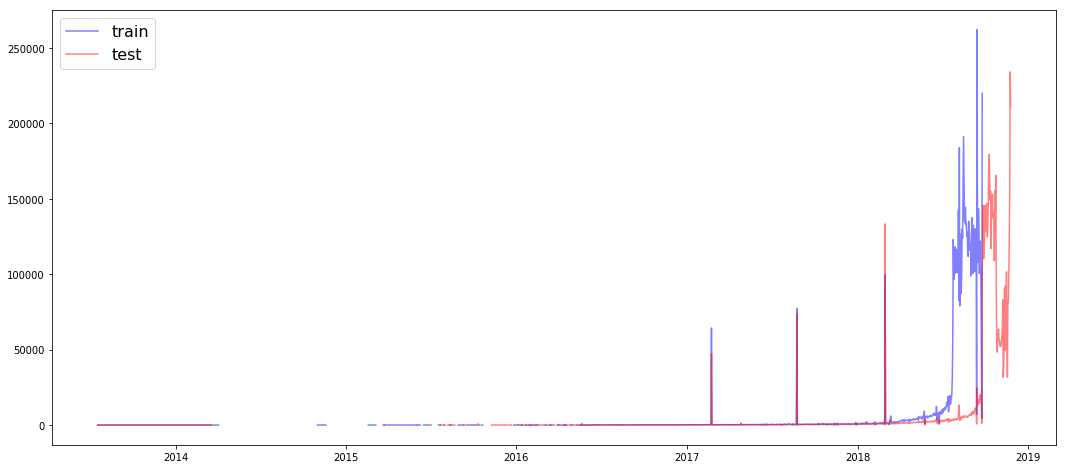

In [25]:
plt.figure(figsize=(18, 8))
plt.plot(tr_temp.Date_YMD, tr_temp['size'], '-', color='b', alpha=0.5, label='train')
plt.plot(te_temp.Date_YMD, te_temp['size'], '-', color='r', alpha=0.5, label='test')
plt.legend(('train', 'test'), prop={'size': 16})

### + Size

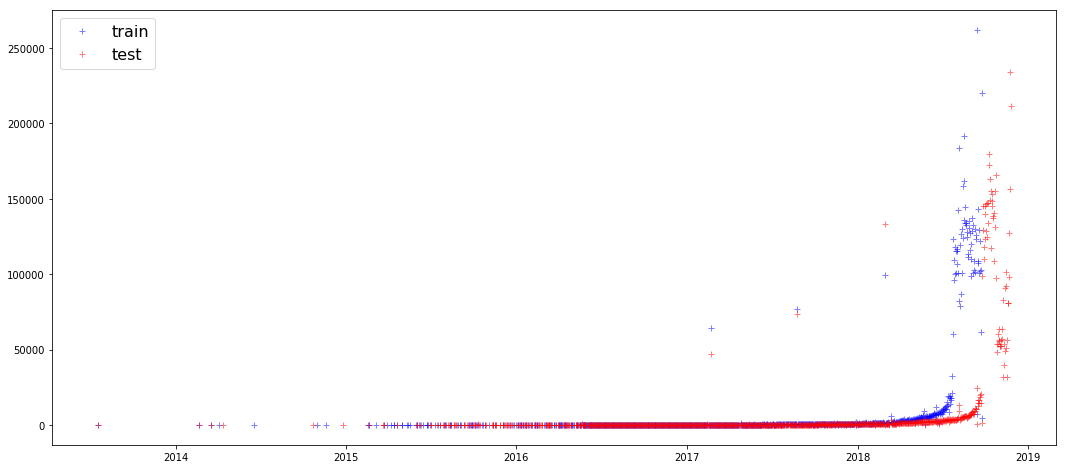

In [22]:
plt.figure(figsize=(18, 8))
plt.plot(tr_temp.Date_YMD, tr_temp['size'], '+', color='b', alpha=0.5, label='train')
plt.plot(te_temp.Date_YMD, te_temp['size'], '+', color='r', alpha=0.5, label='test')
plt.legend(('train', 'test'), prop={'size': 16})

### - Detection Rate

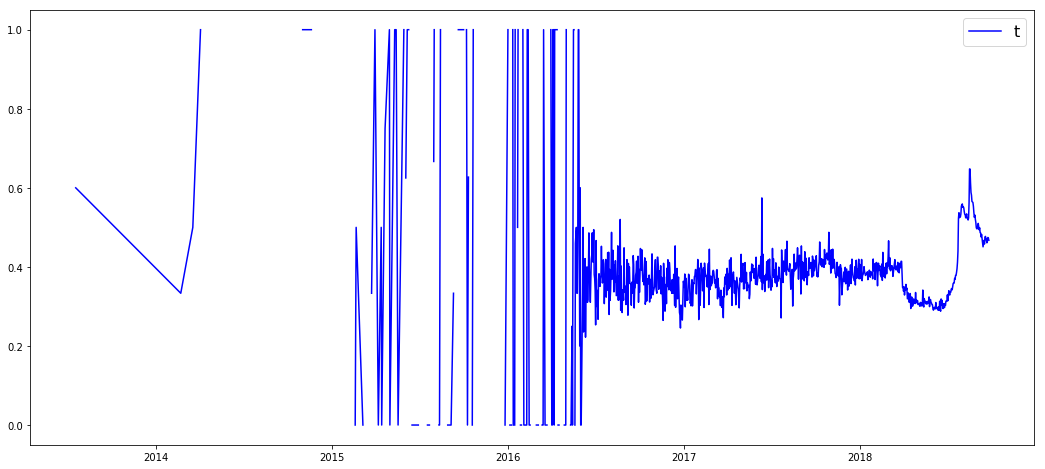

In [23]:
plt.figure(figsize=(18, 8))
plt.plot(tr_temp.Date_YMD, tr_temp['mean'], '-', color='b', alpha=1, label='train')
plt.legend(('train'), prop={'size': 16})

### + Detection Rate

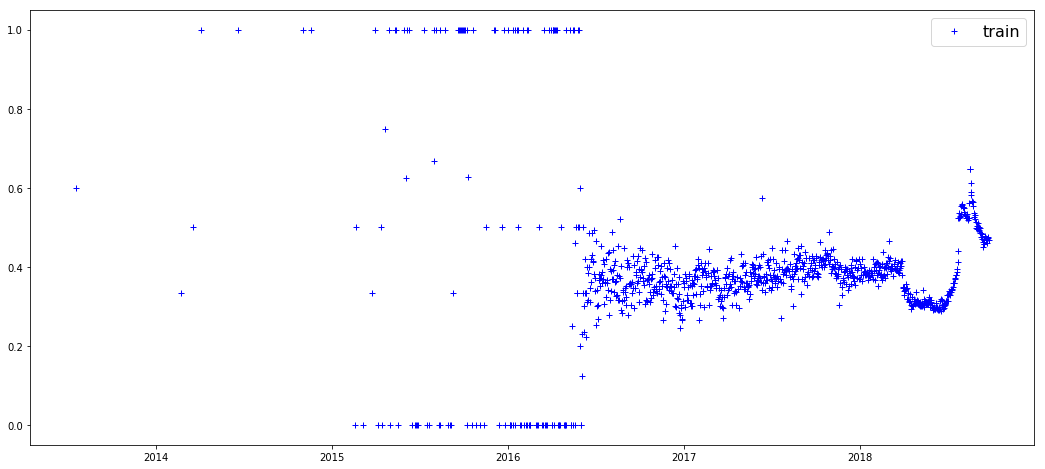

In [24]:
plt.figure(figsize=(18, 8))
plt.plot(tr_temp.Date_YMD, tr_temp['mean'], '+', color='b', alpha=1, label='train')
plt.legend(prop={'size': 16})

### Threshold

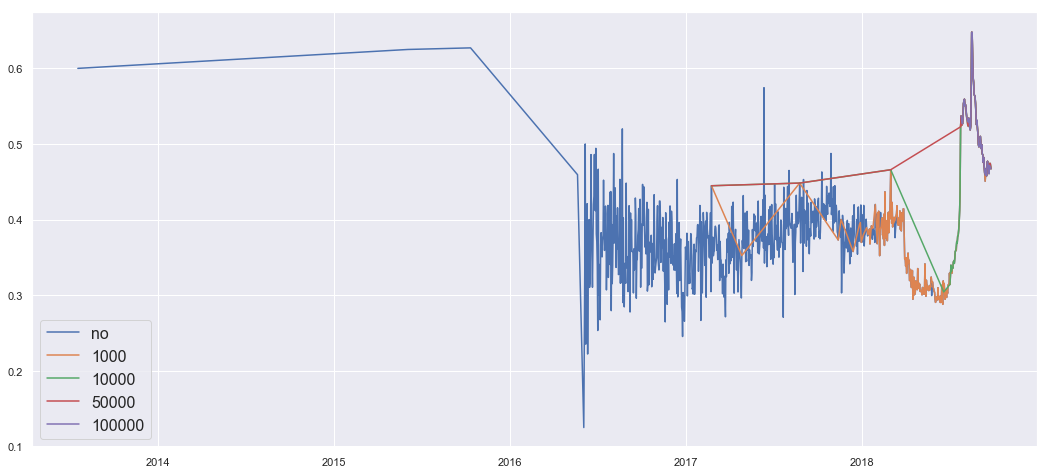

In [313]:
plt.figure(figsize=(18, 8))
threshold = 5
plt.plot(tr_temp[tr_temp['size'] > threshold].Date_YMD, tr_temp[tr_temp['size'] > threshold]['mean'], '-', alpha=1, label=threshold)

threshold = 1000
plt.plot(tr_temp[tr_temp['size'] > threshold].Date_YMD, tr_temp[tr_temp['size'] > threshold]['mean'], '-', alpha=1, label=threshold)

threshold = 10000
plt.plot(tr_temp[tr_temp['size'] > threshold].Date_YMD, tr_temp[tr_temp['size'] > threshold]['mean'], '-', alpha=1, label=threshold)

threshold = 50000
plt.plot(tr_temp[tr_temp['size'] > threshold].Date_YMD, tr_temp[tr_temp['size'] > threshold]['mean'], '-', alpha=1, label=threshold)

threshold = 100000
plt.plot(tr_temp[tr_temp['size'] > threshold].Date_YMD, tr_temp[tr_temp['size'] > threshold]['mean'], '-', alpha=1, label=threshold)

plt.legend(('no', '1000', '10000', '50000', '100000'), prop={'size': 16})

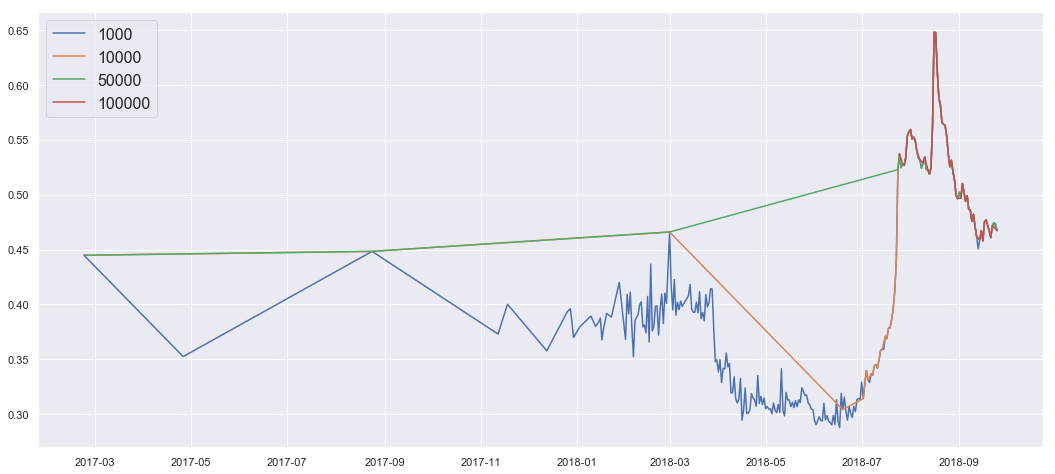

In [306]:
plt.figure(figsize=(18, 8))

threshold = 1000
plt.plot(tr_temp[tr_temp['size'] > threshold].Date_YMD, tr_temp[tr_temp['size'] > threshold]['mean'], '-', alpha=1, label=threshold)

threshold = 10000
plt.plot(tr_temp[tr_temp['size'] > threshold].Date_YMD, tr_temp[tr_temp['size'] > threshold]['mean'], '-', alpha=1, label=threshold)

threshold = 50000
plt.plot(tr_temp[tr_temp['size'] > threshold].Date_YMD, tr_temp[tr_temp['size'] > threshold]['mean'], '-', alpha=1, label=threshold)

threshold = 100000
plt.plot(tr_temp[tr_temp['size'] > threshold].Date_YMD, tr_temp[tr_temp['size'] > threshold]['mean'], '-', alpha=1, label=threshold)

plt.legend(('1000', '10000', '50000', '100000'), prop={'size': 16})

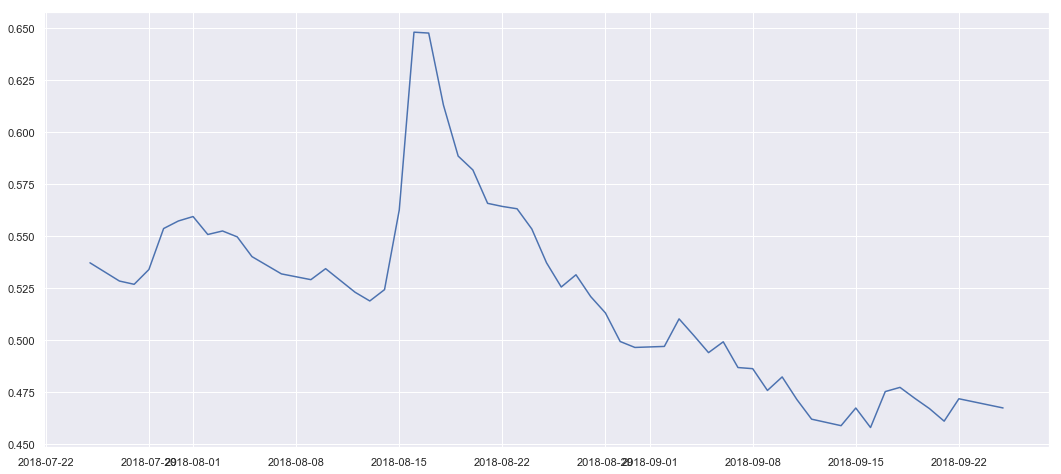

In [319]:
plt.figure(figsize=(18, 8))

threshold = 100000
plt.plot(tr_temp[tr_temp['size'] > threshold].Date_YMD, tr_temp[tr_temp['size'] > threshold]['mean'], '-', alpha=1, label=threshold)

## 2017 이후

In [228]:
tr_temp = tr_temp[tr_temp.Date_YMD > '2017-01-01']
te_temp = te_temp[te_temp.Date_YMD > '2017-01-01']

### - Size

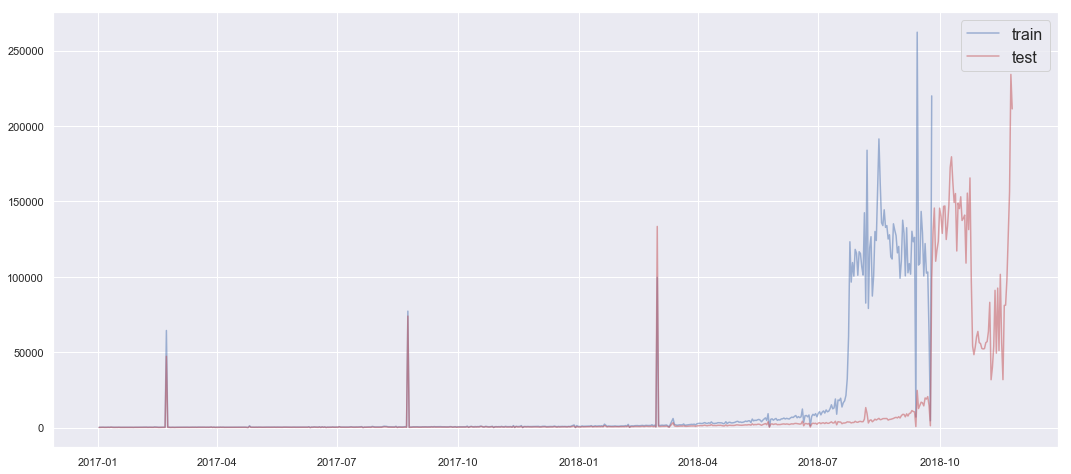

In [232]:
plt.figure(figsize=(18, 8))
plt.plot(tr_temp.Date_YMD, tr_temp['size'], '-', color='b', alpha=0.5, label='train')
plt.plot(te_temp.Date_YMD, te_temp['size'], '-', color='r', alpha=0.5, label='test')
plt.legend(('train', 'test'), prop={'size': 16})

### + Size

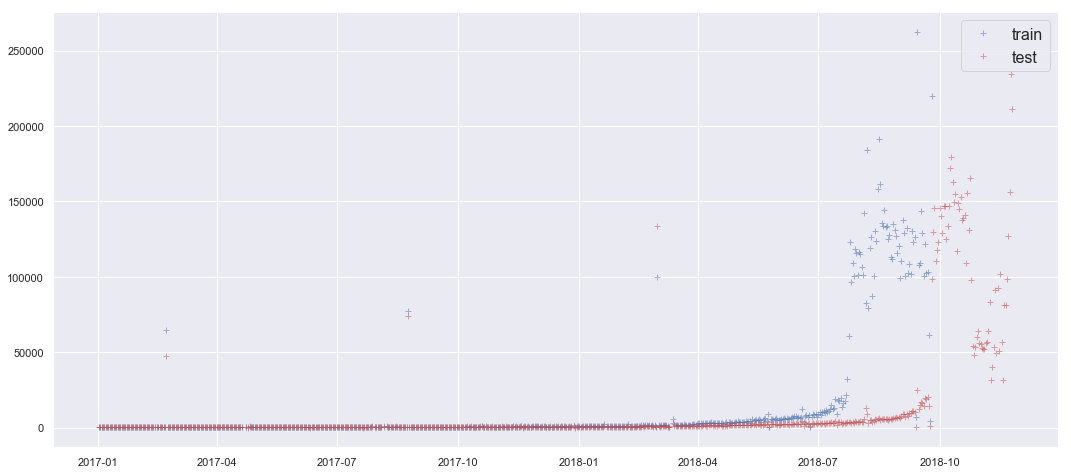

In [229]:
plt.figure(figsize=(18, 8))
plt.plot(tr_temp.Date_YMD, tr_temp['size'], '+', color='b', alpha=0.5, label='train')
plt.plot(te_temp.Date_YMD, te_temp['size'], '+', color='r', alpha=0.5, label='test')
plt.legend(('train', 'test'), prop={'size': 16})

### - Detection Rate

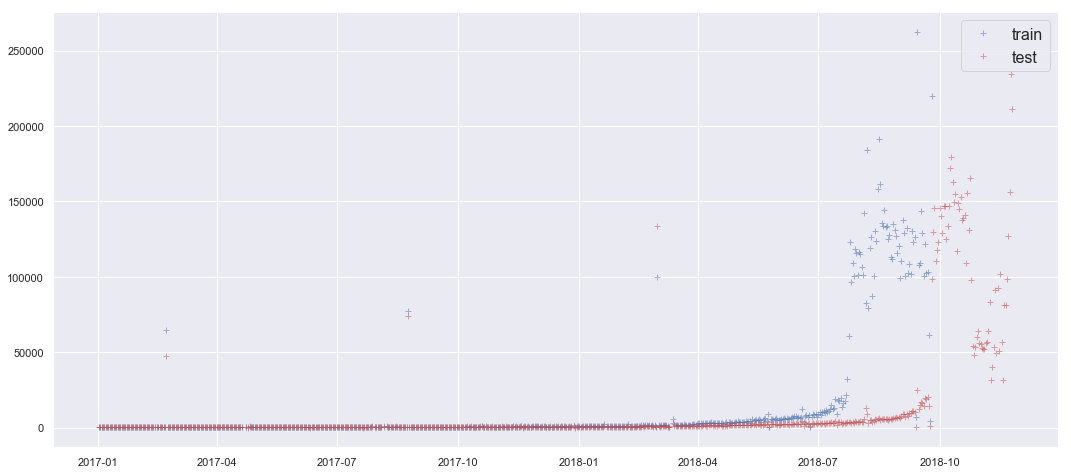

In [229]:
plt.figure(figsize=(18, 8))
plt.plot(tr_temp.Date_YMD, tr_temp['size'], '-', color='b', alpha=0.5, label='train')
plt.plot(te_temp.Date_YMD, te_temp['size'], '-', color='r', alpha=0.5, label='test')
plt.legend(('train', 'test'), prop={'size': 16})

### + Detection Rate

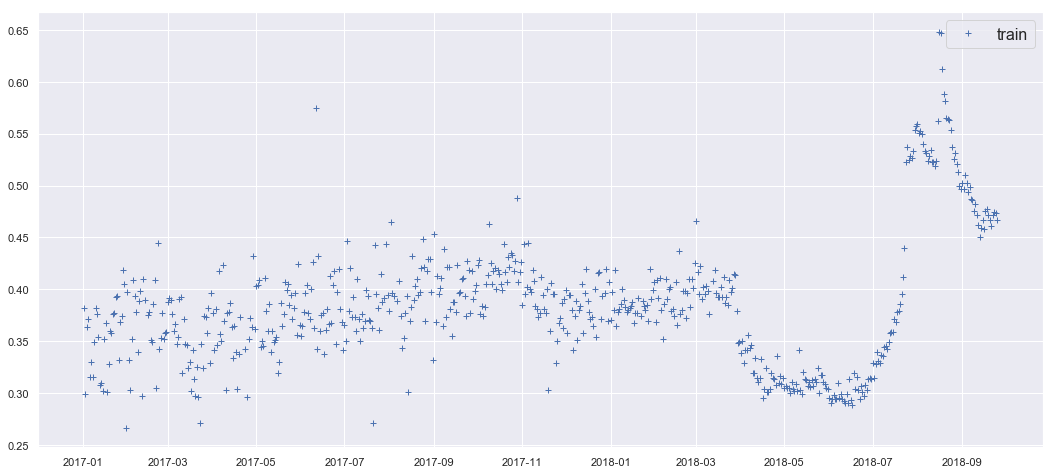

In [231]:
plt.figure(figsize=(18, 8))
plt.plot(tr_temp.Date_YMD, tr_temp['mean'], '+', color='b', alpha=1, label='train')
plt.legend(prop={'size': 16})

### Threshold

In [279]:
tr_temp[tr_temp > 100000]['size'].sum()

7035250.0

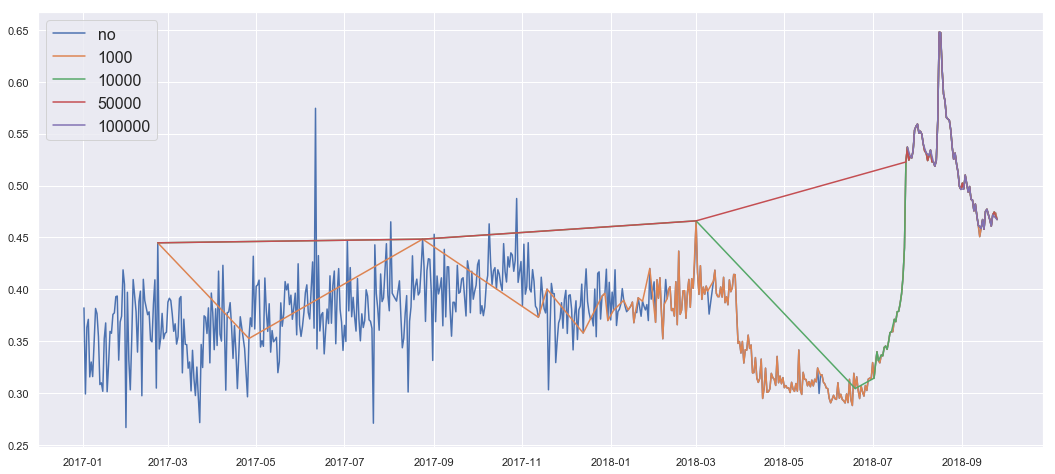

In [283]:
plt.figure(figsize=(18, 8))
threshold = 1
plt.plot(tr_temp[tr_temp['size'] > threshold].Date_YMD, tr_temp[tr_temp['size'] > threshold]['mean'], '-', alpha=1, label=threshold)

threshold = 1000
plt.plot(tr_temp[tr_temp['size'] > threshold].Date_YMD, tr_temp[tr_temp['size'] > threshold]['mean'], '-', alpha=1, label=threshold)

threshold = 10000
plt.plot(tr_temp[tr_temp['size'] > threshold].Date_YMD, tr_temp[tr_temp['size'] > threshold]['mean'], '-', alpha=1, label=threshold)

threshold = 50000
plt.plot(tr_temp[tr_temp['size'] > threshold].Date_YMD, tr_temp[tr_temp['size'] > threshold]['mean'], '-', alpha=1, label=threshold)

threshold = 100000
plt.plot(tr_temp[tr_temp['size'] > threshold].Date_YMD, tr_temp[tr_temp['size'] > threshold]['mean'], '-', alpha=1, label=threshold)

plt.legend(('no', '1000', '10000', '50000', '100000'), prop={'size': 16})

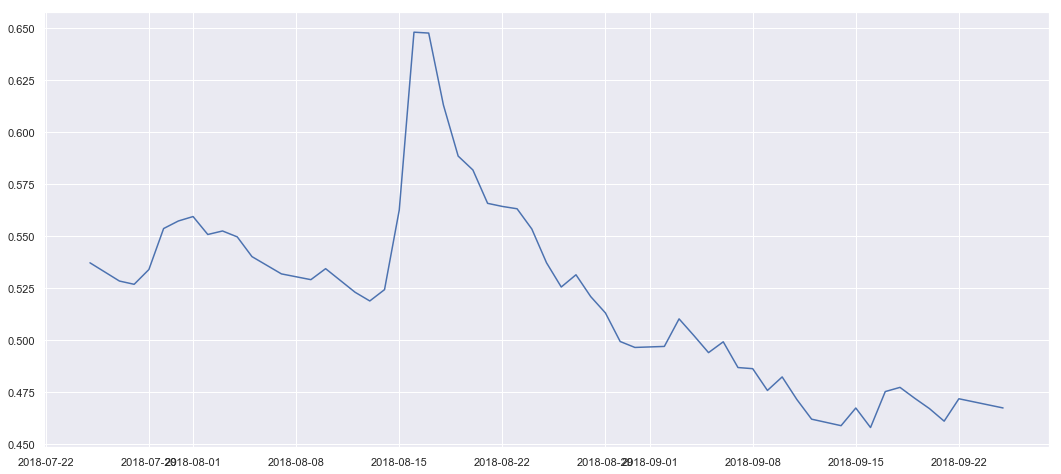

In [284]:
plt.figure(figsize=(18, 8))
threshold = 100000
plt.plot(tr_temp[tr_temp['size'] > threshold].Date_YMD, tr_temp[tr_temp['size'] > threshold]['mean'], '-', alpha=1, label=threshold)

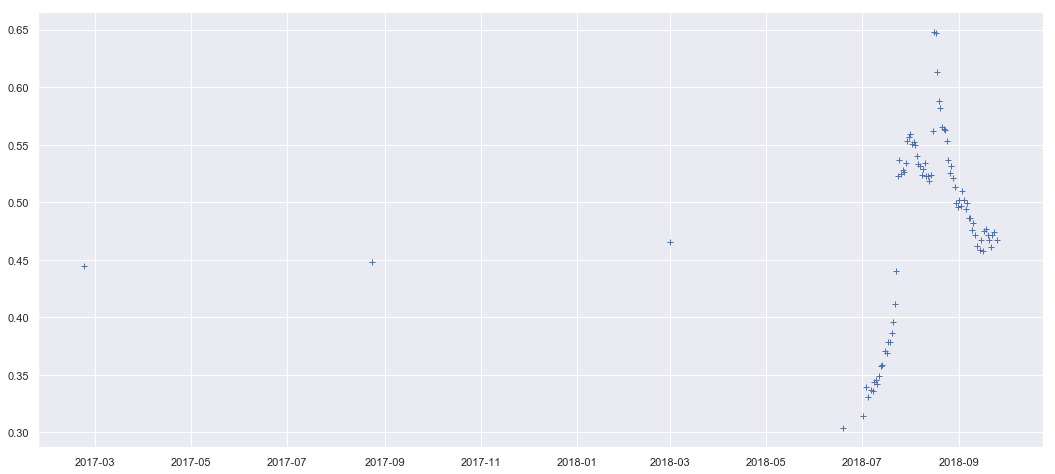

In [294]:
plt.figure(figsize=(18, 8))
threshold = 10000
plt.plot(tr_temp[tr_temp['size'] > threshold].Date_YMD, tr_temp[tr_temp['size'] > threshold]['mean'], '+', alpha=1, label=threshold)

# Time Plot - OsVersion

In [343]:
data.head()

,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsVer,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IsProtected,AutoSampleOptIn,PuaMode,SMode,IeVerIdentifier,SmartScreen,Firewall,UacLuaenable,Census_MDC2FormFactor,Census_DeviceFamily,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_ProcessorClass,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_IsFlightsDisabled,Census_FlightRing,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections,Date,Date_YMD,DateFromOsVersion
0,0,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1735.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,29,128035.0,18.0,35.0,-85,windows10,x64,10.0.0.0,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,1.0,0,NaN,0.0,137.0,NaN,1.0,1.0,Desktop,Windows.Desktop,2668.0,9124.0,4.0,5.0,2340.0,NaN,476940.0,HDD,299451.0,0,4096.0,Desktop,18.906250,1440.0,900.0,Desktop,NaN,4.294967e+09,10.0.17134.165,amd64,rs4_release,17134,165,Professional,PROFESSIONAL,UUPUpgrade,26.0,119,UNKNOWN,0,IS_GENUINE,Retail,NaN,0.0,Retail,NaN,628.0,36144.0,0,NaN,0.0,0,0,0.0,0.0,10.0,0.0,2018-08-20 21:11:00,2018-08-20,2018-07-10
1,1,win8defender,1.1.14600.4,4.13.17134.1,1.263.48.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,93,1482.0,18.0,119.0,64,windows10,x64,10.0.0.0,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,1.0,0,NaN,0.0,137.0,NaN,1.0,1.0,Notebook,Windows.Desktop,2668.0,91656.0,4.0,5.0,2404.0,NaN,476940.0,HDD,102385.0,0,4096.0,Notebook,13.898438,1366.0,768.0,Mobile,NaN,1.000000e+00,10.0.17134.1,amd64,rs4_release,17134,1,Professional,PROFESSIONAL,IBSClean,8.0,31,UNKNOWN,0,OFFLINE,Retail,NaN,0.0,NOT_SET,NaN,628.0,57858.0,0,NaN,0.0,0,0,0.0,0.0,8.0,0.0,2018-03-01 22:10:00,2018-03-01,2018-04-20
2,2,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1341.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,86,153579.0,18.0,64.0,49,windows10,x64,10.0.0.0,17134,768,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,1.0,0,NaN,0.0,137.0,RequireAdmin,1.0,1.0,Desktop,Windows.Desktop,4908.0,317701.0,4.0,5.0,1972.0,NaN,114473.0,SSD,113907.0,0,4096.0,Desktop,21.500000,1920.0,1080.0,Desktop,NaN,4.294967e+09,10.0.17134.165,amd64,rs4_release,17134,165,Core,CORE,UUPUpgrade,7.0,30,FullAuto,0,IS_GENUINE,OEM:NONSLP,NaN,0.0,Retail,NaN,142.0,52682.0,0,NaN,0.0,0,0,0.0,0.0,3.0,0.0,2018-08-13 23:35:00,2018-08-13,2018-07-10
3,3,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1527.0,0,7.0,0,NaN,53447.0,1.0,1.0,1,88,20710.0,NaN,117.0,115,windows10,x64,10.0.0.0,17134,256,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,1.0,0,NaN,0.0,137.0,ExistsNotSet,1.0,1.0,Desktop,Windows.Desktop,1443.0,275890.0,4.0,5.0,2272.0,NaN,238475.0,UNKNOWN,227116.0,0,4096.0,MiniTower,18.500000,1366.0,768.0,Desktop,NaN,4.294967e+09,10.0

In [344]:
time_idx = data.groupby(['DateFromOsVersion']).size().index

In [345]:
train = data[~data.HasDetections.isna()]
test = data[data.HasDetections.isna()]

In [346]:
temp = pd.DataFrame(time_idx)

In [347]:
tr_temp = train.groupby('DateFromOsVersion').HasDetections.agg(['size', 'mean']).reset_index()
te_temp = test.groupby('DateFromOsVersion').HasDetections.agg(['size', 'mean']).reset_index()

In [348]:
tr_temp = temp.merge(tr_temp, on='DateFromOsVersion', how='left')#.fillna(0)
te_temp = temp.merge(te_temp, on='DateFromOsVersion', how='left')#.fillna(0)

## 전체

### - Size

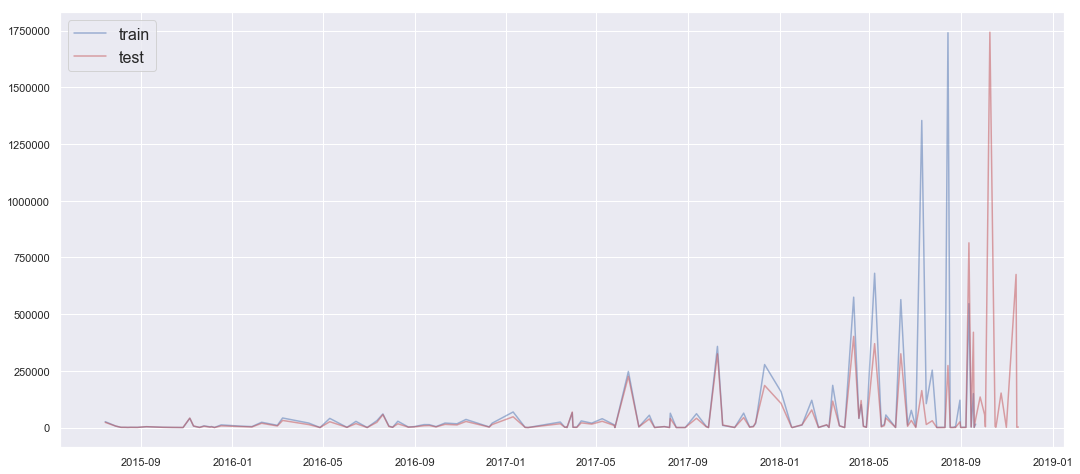

In [349]:
plt.figure(figsize=(18, 8))
plt.plot(tr_temp.DateFromOsVersion, tr_temp['size'], '-', color='b', alpha=0.5, label='train')
plt.plot(te_temp.DateFromOsVersion, te_temp['size'], '-', color='r', alpha=0.5, label='test')
plt.legend(('train', 'test'), prop={'size': 16})

### + Size

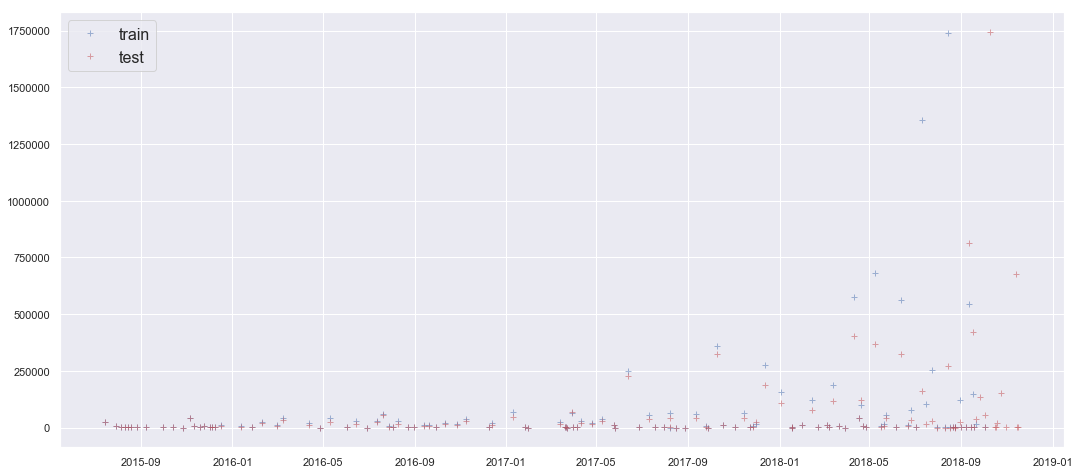

In [351]:
plt.figure(figsize=(18, 8))
plt.plot(tr_temp.DateFromOsVersion, tr_temp['size'], '+', color='b', alpha=0.5, label='train')
plt.plot(te_temp.DateFromOsVersion, te_temp['size'], '+', color='r', alpha=0.5, label='test')
plt.legend(('train', 'test'), prop={'size': 16})

### - Detection Rate

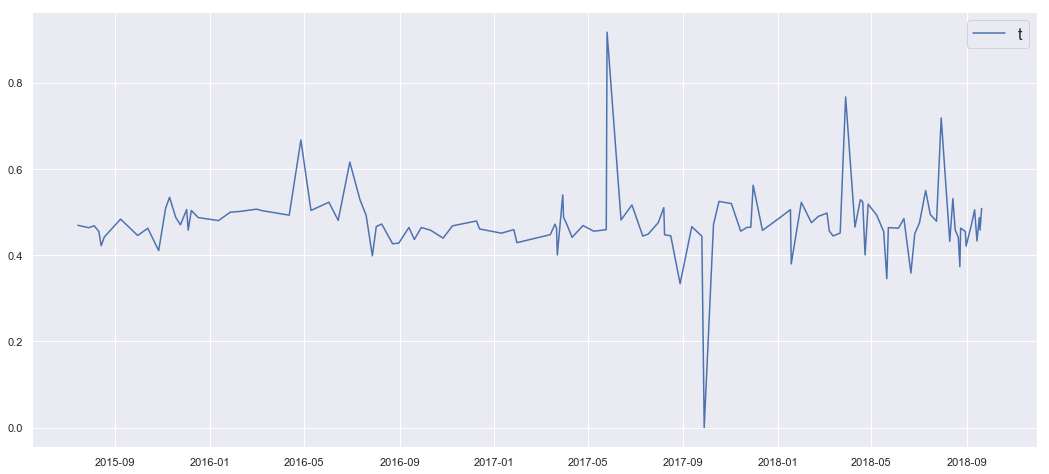

In [352]:
plt.figure(figsize=(18, 8))
plt.plot(tr_temp.DateFromOsVersion, tr_temp['mean'], '-', color='b', alpha=1, label='train')
plt.legend(('train'), prop={'size': 16})

### + Detection Rate

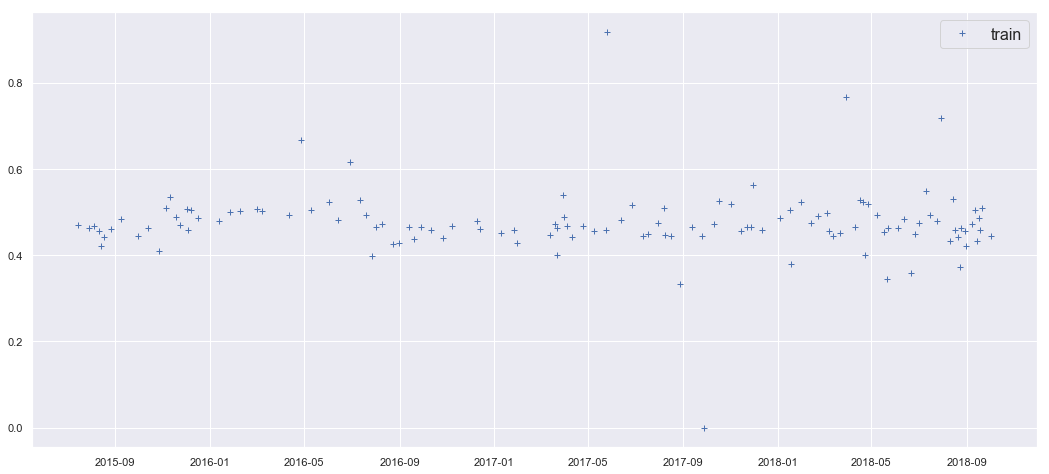

In [353]:
plt.figure(figsize=(18, 8))
plt.plot(tr_temp.DateFromOsVersion, tr_temp['mean'], '+', color='b', alpha=1, label='train')
plt.legend(prop={'size': 16})

### Threshold

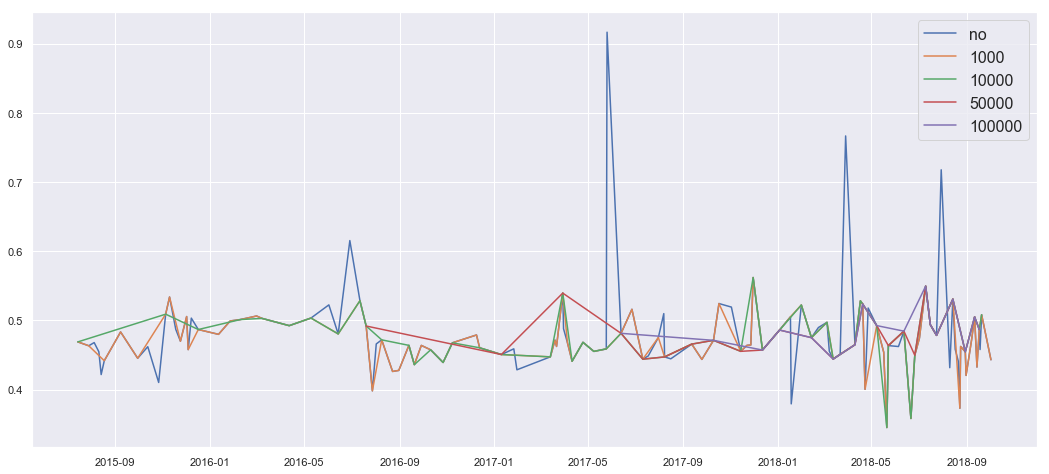

In [354]:
plt.figure(figsize=(18, 8))
threshold = 5
plt.plot(tr_temp[tr_temp['size'] > threshold].DateFromOsVersion, tr_temp[tr_temp['size'] > threshold]['mean'], '-', alpha=1, label=threshold)

threshold = 1000
plt.plot(tr_temp[tr_temp['size'] > threshold].DateFromOsVersion, tr_temp[tr_temp['size'] > threshold]['mean'], '-', alpha=1, label=threshold)

threshold = 10000
plt.plot(tr_temp[tr_temp['size'] > threshold].DateFromOsVersion, tr_temp[tr_temp['size'] > threshold]['mean'], '-', alpha=1, label=threshold)

threshold = 50000
plt.plot(tr_temp[tr_temp['size'] > threshold].DateFromOsVersion, tr_temp[tr_temp['size'] > threshold]['mean'], '-', alpha=1, label=threshold)

threshold = 100000
plt.plot(tr_temp[tr_temp['size'] > threshold].DateFromOsVersion, tr_temp[tr_temp['size'] > threshold]['mean'], '-', alpha=1, label=threshold)

plt.legend(('no', '1000', '10000', '50000', '100000'), prop={'size': 16})

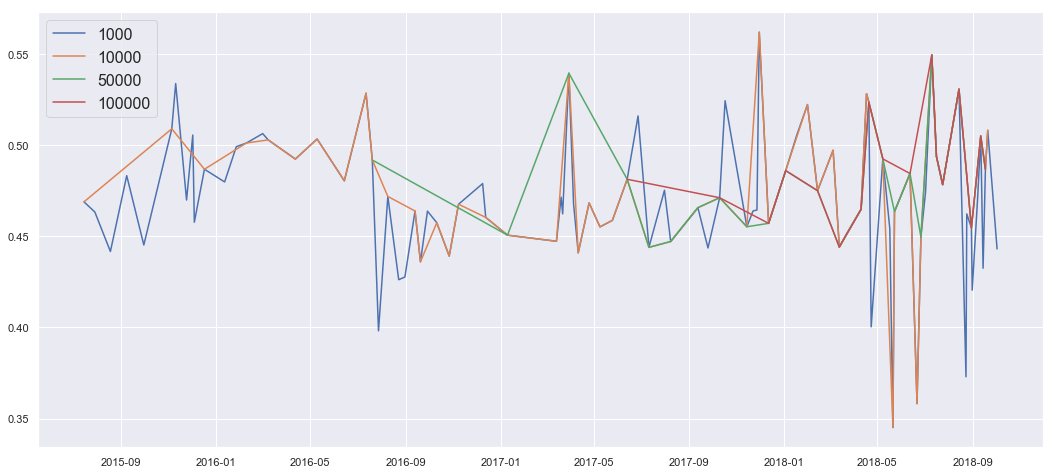

In [355]:
plt.figure(figsize=(18, 8))

threshold = 1000
plt.plot(tr_temp[tr_temp['size'] > threshold].DateFromOsVersion, tr_temp[tr_temp['size'] > threshold]['mean'], '-', alpha=1, label=threshold)

threshold = 10000
plt.plot(tr_temp[tr_temp['size'] > threshold].DateFromOsVersion, tr_temp[tr_temp['size'] > threshold]['mean'], '-', alpha=1, label=threshold)

threshold = 50000
plt.plot(tr_temp[tr_temp['size'] > threshold].DateFromOsVersion, tr_temp[tr_temp['size'] > threshold]['mean'], '-', alpha=1, label=threshold)

threshold = 100000
plt.plot(tr_temp[tr_temp['size'] > threshold].DateFromOsVersion, tr_temp[tr_temp['size'] > threshold]['mean'], '-', alpha=1, label=threshold)

plt.legend(('1000', '10000', '50000', '100000'), prop={'size': 16})

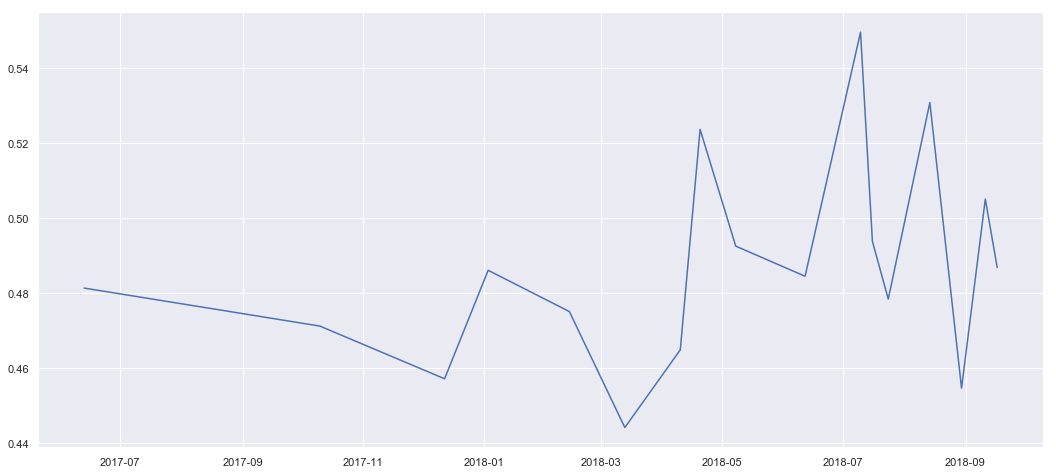

In [356]:
plt.figure(figsize=(18, 8))

threshold = 100000
plt.plot(tr_temp[tr_temp['size'] > threshold].DateFromOsVersion, tr_temp[tr_temp['size'] > threshold]['mean'], '-', alpha=1, label=threshold)

## 2017 이후

In [363]:
tr_temp = tr_temp[tr_temp.DateFromOsVersion > '2017-01-01']
te_temp = te_temp[te_temp.DateFromOsVersion > '2017-01-01']

### - Size

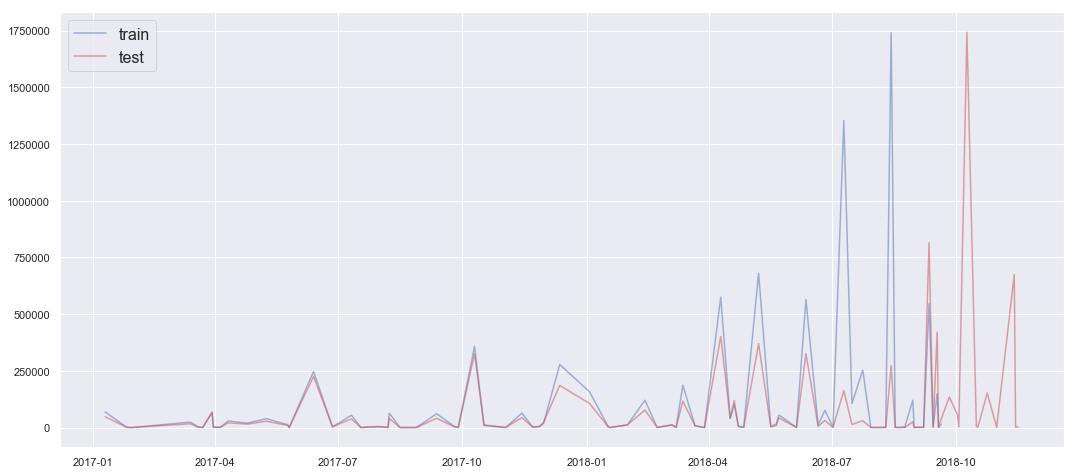

In [364]:
plt.figure(figsize=(18, 8))
plt.plot(tr_temp.DateFromOsVersion, tr_temp['size'], '-', color='b', alpha=0.5, label='train')
plt.plot(te_temp.DateFromOsVersion, te_temp['size'], '-', color='r', alpha=0.5, label='test')
plt.legend(('train', 'test'), prop={'size': 16})

### + Size

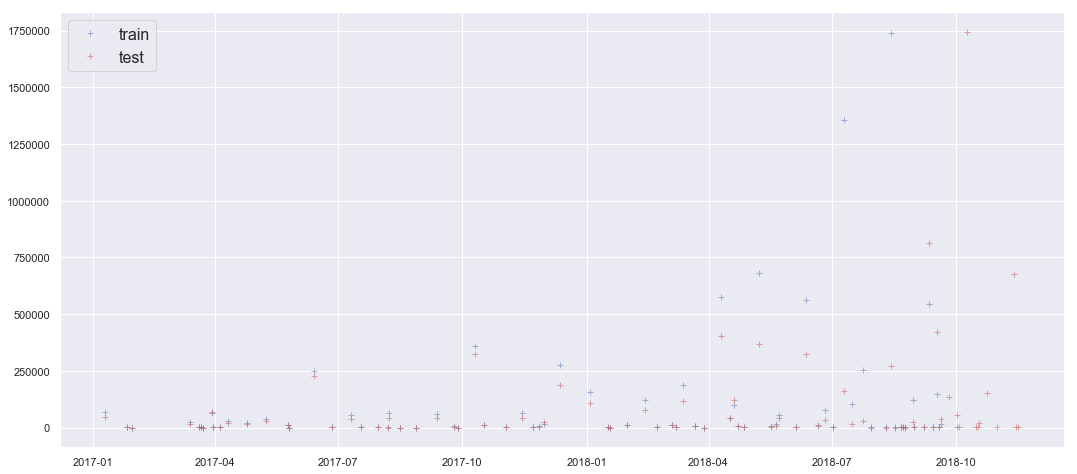

In [365]:
plt.figure(figsize=(18, 8))
plt.plot(tr_temp.DateFromOsVersion, tr_temp['size'], '+', color='b', alpha=0.5, label='train')
plt.plot(te_temp.DateFromOsVersion, te_temp['size'], '+', color='r', alpha=0.5, label='test')
plt.legend(('train', 'test'), prop={'size': 16})

### - Detection Rate

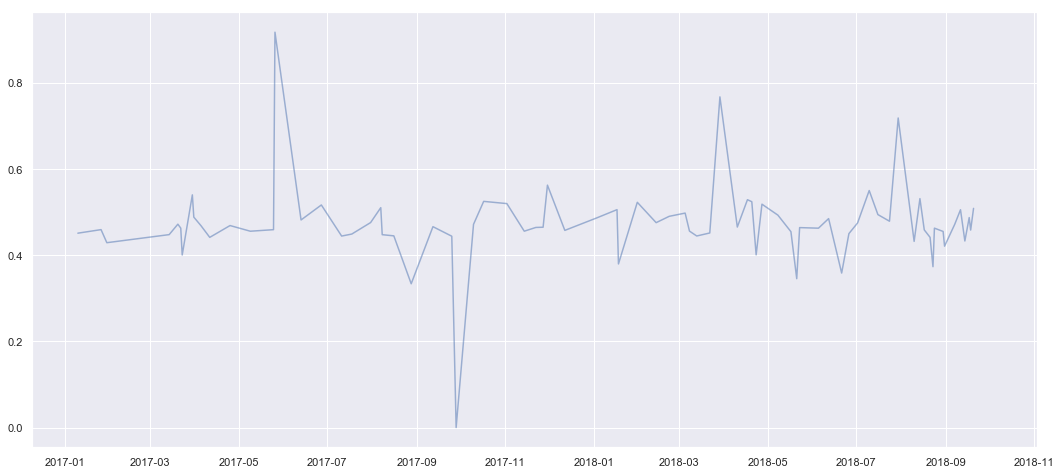

In [366]:
plt.figure(figsize=(18, 8))
plt.plot(tr_temp.DateFromOsVersion, tr_temp['mean'], '-', color='b', alpha=0.5, label='train')

### + Detection Rate

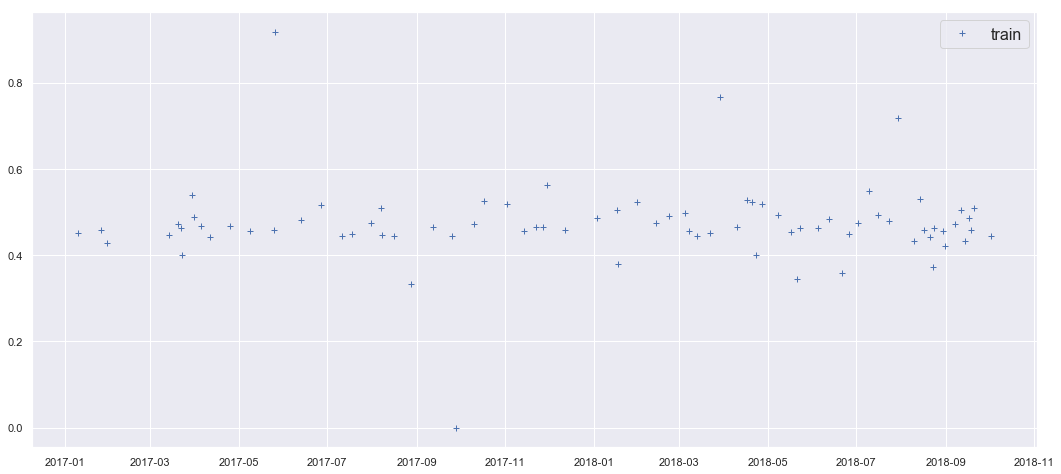

In [367]:
plt.figure(figsize=(18, 8))
plt.plot(tr_temp.DateFromOsVersion, tr_temp['mean'], '+', color='b', alpha=1, label='train')
plt.legend(prop={'size': 16})

### Threshold

In [368]:
tr_temp[tr_temp > 100000]['size'].sum()

7536692.0

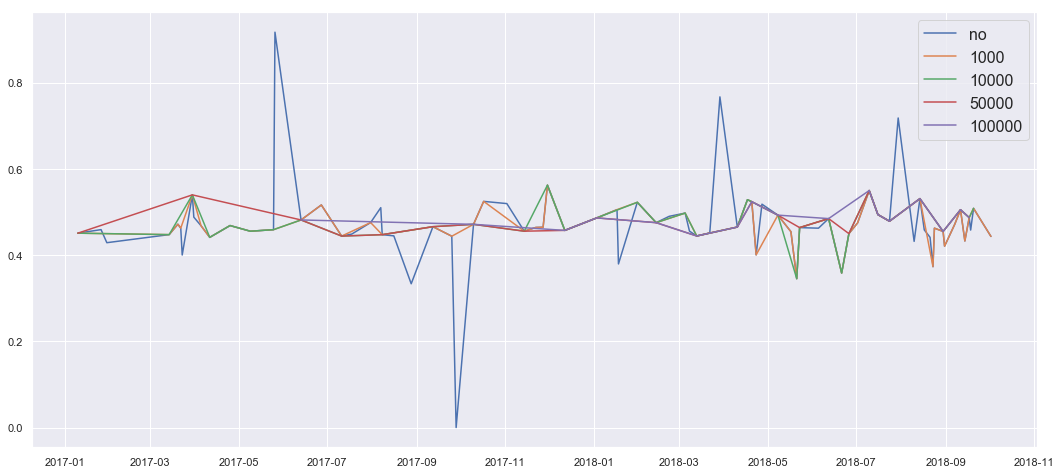

In [369]:
plt.figure(figsize=(18, 8))
threshold = 1
plt.plot(tr_temp[tr_temp['size'] > threshold].DateFromOsVersion, tr_temp[tr_temp['size'] > threshold]['mean'], '-', alpha=1, label=threshold)

threshold = 1000
plt.plot(tr_temp[tr_temp['size'] > threshold].DateFromOsVersion, tr_temp[tr_temp['size'] > threshold]['mean'], '-', alpha=1, label=threshold)

threshold = 10000
plt.plot(tr_temp[tr_temp['size'] > threshold].DateFromOsVersion, tr_temp[tr_temp['size'] > threshold]['mean'], '-', alpha=1, label=threshold)

threshold = 50000
plt.plot(tr_temp[tr_temp['size'] > threshold].DateFromOsVersion, tr_temp[tr_temp['size'] > threshold]['mean'], '-', alpha=1, label=threshold)

threshold = 100000
plt.plot(tr_temp[tr_temp['size'] > threshold].DateFromOsVersion, tr_temp[tr_temp['size'] > threshold]['mean'], '-', alpha=1, label=threshold)

plt.legend(('no', '1000', '10000', '50000', '100000'), prop={'size': 16})

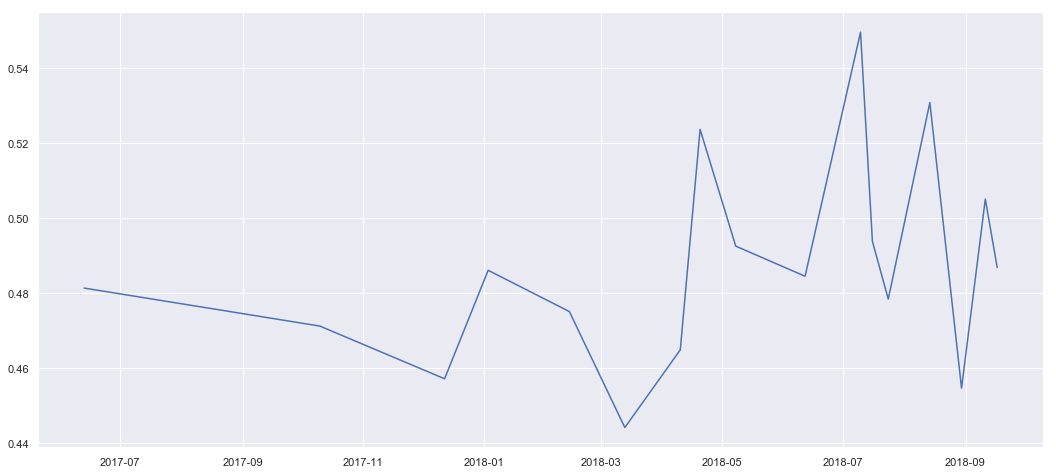

In [370]:
plt.figure(figsize=(18, 8))
threshold = 100000
plt.plot(tr_temp[tr_temp['size'] > threshold].DateFromOsVersion, tr_temp[tr_temp['size'] > threshold]['mean'], '-', alpha=1, label=threshold)

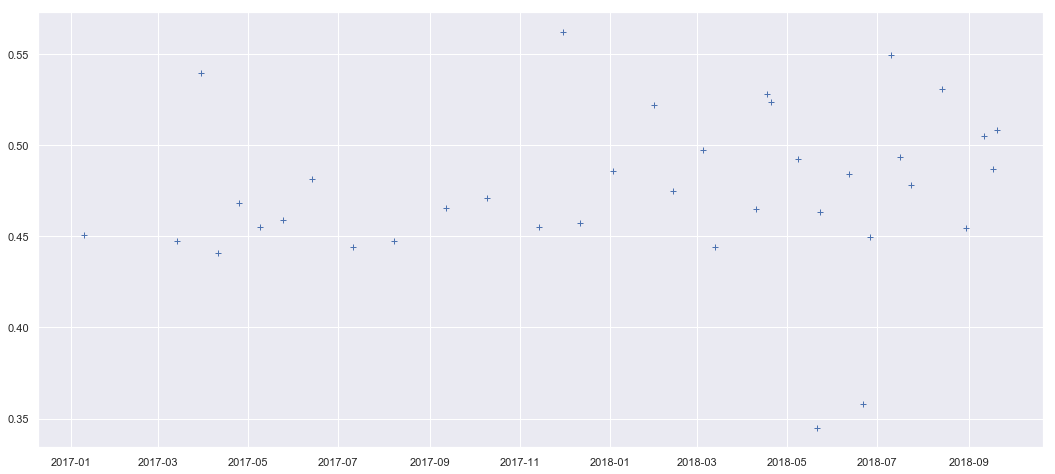

In [371]:
plt.figure(figsize=(18, 8))
threshold = 10000
plt.plot(tr_temp[tr_temp['size'] > threshold].DateFromOsVersion, tr_temp[tr_temp['size'] > threshold]['mean'], '+', alpha=1, label=threshold)

# Time With AV

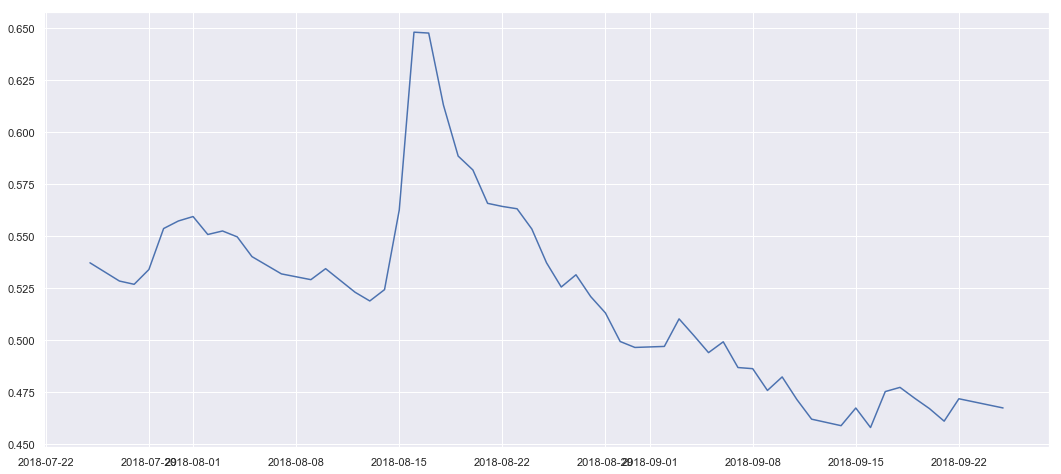

In [284]:
plt.figure(figsize=(18, 8))
threshold = 100000
plt.plot(tr_temp[tr_temp['size'] > threshold].Date_YMD, tr_temp[tr_temp['size'] > threshold]['mean'], '-', alpha=1, label=threshold)

In [375]:
av_threats = pd.read_csv('./data/AvSigversion_Threats.csv')

In [392]:
av_threats = av_threats.groupby(['AvSigVersion', 'Type', 'Name']).size().reset_index().drop([0],axis=1)

In [414]:
data[(data.Date_YMD >= '2018-08-08') & (data.Date_YMD <= '2018-8-22')].groupby(['Date_YMD']).HasDetections.mean()

Date_YMD
2018-08-08    0.524118
2018-08-09    0.528892
2018-08-10    0.534173
2018-08-11    0.522918
2018-08-12    0.522841
2018-08-13    0.518653
2018-08-14    0.524096
2018-08-15    0.562375
2018-08-16    0.647854
2018-08-17    0.647432
2018-08-18    0.612826
2018-08-19    0.588300
2018-08-20    0.581623
2018-08-21    0.565578
2018-08-22    0.564092
Name: HasDetections, dtype: float64

In [421]:
temp = data.groupby(['Date_YMD', 'AvSigVersion']).HasDetections.agg(['mean', 'size']).reset_index()

In [466]:
temp[(temp['size'] > threshold) & ~temp['mean'].isna()]['size'].sum()

5006588

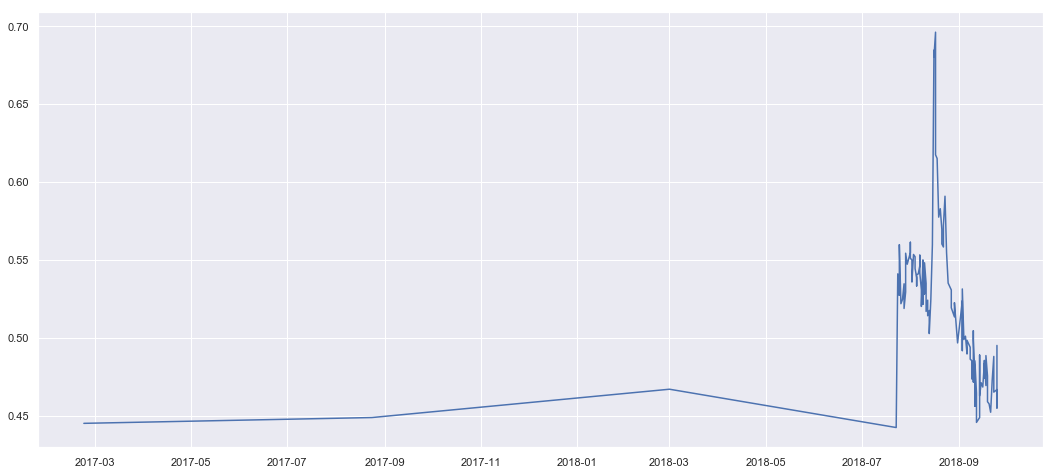

In [473]:
plt.figure(figsize=(18, 8))
threshold = 15000
plt.plot(temp[temp['size'] > threshold].Date_YMD, temp[temp['size'] > threshold]['mean'], '-', alpha=1, label=threshold)

In [422]:
temp

,Date_YMD,AvSigVersion,mean,size
0,2013-07-18,1.155.266.0,0.600000,21
1,2014-02-21,1.167.387.0,0.333333,5
2,2014-03-18,1.169.55.0,0.500000,5
3,2014-04-03,1.169.1625.0,1.000000,1
4,2014-04-12,1.169.2478.0,NaN,1
5,2014-06-19,1.177.229.0,1.000000,1
6,2014-10-23,1.187.322.0,NaN,1
7,2014-11-01,1.187.1121.0,1.000000,1
8,2014-11-19,1.189.189.0,1.000000,1
9,2014-12-25,1.191.897.0,NaN,1


In [402]:
data[data.Date_YMD == '2018-08-16'].AvSigVersion.unique()

array(['1.273.1471.0', '1.273.1523.0', '1.273.1494.0', '1.273.1516.0',
       '1.273.1505.0', '1.273.1498.0', '1.273.1490.0', '1.273.1504.0',
       '1.273.1478.0', '1.273.1509.0', '1.273.1468.0', '1.273.1465.0',
       '1.273.1519.0', '1.273.1482.0', '1.273.1486.0', '1.273.1501.0',
       '1.273.1512.0', '1.273.1520.0', '1.273.1475.0'], dtype=object)

In [405]:
for sig_ver in data[data.Date_YMD == '2018-08-16'].AvSigVersion.unique():
    print(av_threats[av_threats.AvSigVersion == sig_ver])

        AvSigVersion            Type                            Name
878336  1.273.1471.0    AddedThreats             Trojan:Win32/Pervcb
878337  1.273.1471.0  UpdatedThreats        Adware:MSIL/CsdiMonetize
878338  1.273.1471.0  UpdatedThreats        Trojan:JS/Redirector!rfn
878339  1.273.1471.0  UpdatedThreats      Trojan:Win32/CoinMiner!rfn
878340  1.273.1471.0  UpdatedThreats      Trojan:Win32/Skeeyah.A!rfn
878341  1.273.1471.0  UpdatedThreats   TrojanClicker:HTML/Iframe!rfn
878342  1.273.1471.0  UpdatedThreats  TrojanClicker:JS/Faceliker!rfn
878343  1.273.1471.0  UpdatedThreats          Worm:Win32/Gamarue!rfn
        AvSigVersion            Type                             Name
880105  1.273.1523.0    AddedThreats               Trojan:Win32/Drspf
880106  1.273.1523.0    AddedThreats        TrojanSpy:Win32/Mekotio.C
880107  1.273.1523.0  UpdatedThreats     Exploit:O97M/CVE-2017-8570.H
880108  1.273.1523.0  UpdatedThreats   SoftwareBundler:Win32/ICLoader
880109  1.273.1523.0  Updated

[355 rows x 3 columns]
Empty DataFrame
Columns: [AvSigVersion, Type, Name]
Index: []
        AvSigVersion            Type                                Name
879083  1.273.1498.0    AddedThreats       Behavior:Win32/CICmstp.B!attk
879084  1.273.1498.0    AddedThreats       TrojanSpy:Win32/Mekotio.C!bit
879085  1.273.1498.0  UpdatedThreats            Backdoor:Linux/Mirai!rfn
879086  1.273.1498.0  UpdatedThreats        Backdoor:MSIL/Bladabindi!rfn
879087  1.273.1498.0  UpdatedThreats              Backdoor:MSIL/Boilod.A
879088  1.273.1498.0  UpdatedThreats            Backdoor:MSIL/Noancooe.B
879089  1.273.1498.0  UpdatedThreats          Backdoor:MSIL/Revetrat!rfn
879090  1.273.1498.0  UpdatedThreats              Backdoor:Win32/Bifrose
879091  1.273.1498.0  UpdatedThreats              Backdoor:Win32/Dodiw.A
879092  1.273.1498.0  UpdatedThreats          Backdoor:Win32/Etumbot!rfn
879093  1.273.1498.0  UpdatedThreats           Backdoor:Win32/Hostil!rfn
879094  1.273.1498.0  UpdatedThreats   

[168 rows x 3 columns]
        AvSigVersion            Type  \
879031  1.273.1490.0    AddedThreats   
879032  1.273.1490.0    AddedThreats   
879033  1.273.1490.0    AddedThreats   
879034  1.273.1490.0  UpdatedThreats   
879035  1.273.1490.0  UpdatedThreats   
879036  1.273.1490.0  UpdatedThreats   
879037  1.273.1490.0  UpdatedThreats   
879038  1.273.1490.0  UpdatedThreats   
879039  1.273.1490.0  UpdatedThreats   
879040  1.273.1490.0  UpdatedThreats   
879041  1.273.1490.0  UpdatedThreats   
879042  1.273.1490.0  UpdatedThreats   
879043  1.273.1490.0  UpdatedThreats   
879044  1.273.1490.0  UpdatedThreats   
879045  1.273.1490.0  UpdatedThreats   
879046  1.273.1490.0  UpdatedThreats   
879047  1.273.1490.0  UpdatedThreats   
879048  1.273.1490.0  UpdatedThreats   
879049  1.273.1490.0  UpdatedThreats   
879050  1.273.1490.0  UpdatedThreats   
879051  1.273.1490.0  UpdatedThreats   
879052  1.273.1490.0  UpdatedThreats   
879053  1.273.1490.0  UpdatedThreats   
879054  1.273.149

[225 rows x 3 columns]
        AvSigVersion            Type                                Name
879563  1.273.1509.0    AddedThreats               Trojan:Win32/Letdater
879564  1.273.1509.0  UpdatedThreats            Adware:MSIL/CsdiMonetize
879565  1.273.1509.0  UpdatedThreats            Backdoor:Linux/Mirai!rfn
879566  1.273.1509.0  UpdatedThreats        Backdoor:MSIL/Bladabindi!rfn
879567  1.273.1509.0  UpdatedThreats            Backdoor:MSIL/Noancooe.C
879568  1.273.1509.0  UpdatedThreats      Backdoor:MacOS_X/Flashback!rfn
879569  1.273.1509.0  UpdatedThreats            Backdoor:Win32/Gaertob.A
879570  1.273.1509.0  UpdatedThreats           Backdoor:Win32/Tofsee!rfn
879571  1.273.1509.0  UpdatedThreats     Exploit:O97M/CVE-2017-11882!rfn
879572  1.273.1509.0  UpdatedThreats          HackTool:Win32/AutoKMS!rfn
879573  1.273.1509.0  UpdatedThreats               PWS:Win32/Mofksys!rfn
879574  1.273.1509.0  UpdatedThreats           Ransom:Win32/GandCrab!rfn
879575  1.273.1509.0  Update

878335  1.273.1468.0  UpdatedThreats                   Worm:Win32/Rebhip
        AvSigVersion            Type                   Name
878239  1.273.1465.0  UpdatedThreats  Adware:Win32/Filetour
878240  1.273.1465.0  UpdatedThreats       Trojan:PDF/Phish
Empty DataFrame
Columns: [AvSigVersion, Type, Name]
Index: []
Empty DataFrame
Columns: [AvSigVersion, Type, Name]
Index: []
        AvSigVersion            Type                                  Name
878569  1.273.1486.0    AddedThreats               Backdoor:Win32/Tiny!rfn
878570  1.273.1486.0    AddedThreats             HackTool:Win64/Eqtool!rfn
878571  1.273.1486.0    AddedThreats                   Trojan:Win64/Adject
878572  1.273.1486.0    AddedThreats                Trojan:Win64/Sathurbot
878573  1.273.1486.0  UpdatedThreats                  Adware:Win32/Adkubru
878574  1.273.1486.0  UpdatedThreats                 Adware:Win32/Filetour
878575  1.273.1486.0  UpdatedThreats                   Adware:Win32/LoudMo
878576  1.273.1486.0  U

[462 rows x 3 columns]
        AvSigVersion            Type                                   Name
879251  1.273.1501.0    AddedThreats             Trojan:Win32/Filoskeed!rfn
879252  1.273.1501.0    AddedThreats                   Trojan:Win32/Panda.A
879253  1.273.1501.0    AddedThreats         TrojanDownloader:O97M/PShell.C
879254  1.273.1501.0  UpdatedThreats                    Adware:Win32/LoudMo
879255  1.273.1501.0  UpdatedThreats               Backdoor:Linux/Mirai!rfn
879256  1.273.1501.0  UpdatedThreats             Backdoor:Linux/Tsunami!rfn
879257  1.273.1501.0  UpdatedThreats           Backdoor:MSIL/Bladabindi!rfn
879258  1.273.1501.0  UpdatedThreats                 Backdoor:MSIL/Boilod.A
879259  1.273.1501.0  UpdatedThreats               Backdoor:MSIL/Noancooe.A
879260  1.273.1501.0  UpdatedThreats               Backdoor:MSIL/Noancooe.C
879261  1.273.1501.0  UpdatedThreats                Backdoor:MSIL/Pontoeb.A
879262  1.273.1501.0  UpdatedThreats         Backdoor:MacOS_X/Fla

[312 rows x 3 columns]
        AvSigVersion            Type                                  Name
879621  1.273.1512.0  UpdatedThreats                   Adware:Win32/LoudMo
879622  1.273.1512.0  UpdatedThreats              Backdoor:Linux/Mirai!rfn
879623  1.273.1512.0  UpdatedThreats          Backdoor:MSIL/Bladabindi!rfn
879624  1.273.1512.0  UpdatedThreats                Backdoor:MSIL/Boilod.A
879625  1.273.1512.0  UpdatedThreats              Backdoor:MSIL/Sisbot!rfn
879626  1.273.1512.0  UpdatedThreats                Backdoor:Win32/Bifrose
879627  1.273.1512.0  UpdatedThreats            Backdoor:Win32/Etumbot!rfn
879628  1.273.1512.0  UpdatedThreats             Backdoor:Win32/Hostil!rfn
879629  1.273.1512.0  UpdatedThreats            Backdoor:Win32/Hupigon!rfn
879630  1.273.1512.0  UpdatedThreats             Backdoor:Win32/IRCbot!rfn
879631  1.273.1512.0  UpdatedThreats           Backdoor:Win32/PcClient!rfn
879632  1.273.1512.0  UpdatedThreats               Backdoor:Win32/Simda.AT
87

879747  1.273.1512.0  UpdatedThreats                  Worm:Win32/Sfone!rfn
        AvSigVersion            Type                          Name
880103  1.273.1520.0  UpdatedThreats  Exploit:O97M/CVE-2017-8570.H
880104  1.273.1520.0  UpdatedThreats       Trojan:Win32/Namrecka.A
Empty DataFrame
Columns: [AvSigVersion, Type, Name]
Index: []


## Train, Test split

In [8]:
train = data[~data.HasDetections.isna()]
test = data[data.HasDetections.isna()]
del data
gc.collect()

14

In [9]:
train.MachineIdentifier = range(len(train))
train.reset_index(drop=True, inplace=True)

test.MachineIdentifier = range(len(test))
test.reset_index(drop=True, inplace=True)

In [10]:
debug = False
if debug:
    train = train[:10000]
    test = test[:10000]

In [11]:
print('Transform all features to category.\n')
for usecol in tqdm_notebook(train.columns.tolist()[1:-1]):

    train[usecol] = train[usecol].astype('str')
    test[usecol] = test[usecol].astype('str')
    
    #Fit LabelEncoder
    le = LabelEncoder().fit(
            np.unique(train[usecol].unique().tolist()+
                      test[usecol].unique().tolist()))

    #At the end 0 will be used for dropped values
    train[usecol] = le.transform(train[usecol])+1
    test[usecol]  = le.transform(test[usecol])+1

    agg_tr = (train
              .groupby([usecol])
              .aggregate({'MachineIdentifier':'count'})
              .reset_index()
              .rename({'MachineIdentifier':'Train'}, axis=1))
    
    agg_te = (test
              .groupby([usecol])
              .aggregate({'MachineIdentifier':'count'})
              .reset_index()
              .rename({'MachineIdentifier':'Test'}, axis=1))

    agg = pd.merge(agg_tr, agg_te, on=usecol, how='outer').replace(np.nan, 0)
    #Select values with more than 1000 observations
    agg = agg[(agg['Train'] > 1000)].reset_index(drop=True)
    agg['Total'] = agg['Train'] + agg['Test']
    #Drop unbalanced values
    agg = agg[(agg['Train'] / agg['Total'] > 0.2) & (agg['Train'] / agg['Total'] < 0.8)]
    agg[usecol+'Copy'] = agg[usecol]
    
    train[usecol] = (pd.merge(train[[usecol]], 
                              agg[[usecol, usecol+'Copy']], 
                              on=usecol, how='left')[usecol+'Copy']
                     .replace(np.nan, 0).astype('int').astype('category'))

    test[usecol]  = (pd.merge(test[[usecol]], 
                              agg[[usecol, usecol+'Copy']], 
                              on=usecol, how='left')[usecol+'Copy']
                     .replace(np.nan, 0).astype('int').astype('category'))

    del le, agg_tr, agg_te, agg, usecol
    gc.collect()

Transform all features to category.



KeyboardInterrupt: 

In [16]:
train.shape

(8921483, 70)

In [9]:
y_train = np.array(train['HasDetections'])
train_ids = train.index
test_ids  = test.index

In [18]:
del train['HasDetections'], train['MachineIdentifier'], test['MachineIdentifier'], test['HasDetections']
gc.collect()

74

In [18]:
print("If you don't want use Sparse Matrix choose Kernel Version 2 to get simple solution.\n")

print('--------------------------------------------------------------------------------------------------------')
print('Transform Data to Sparse Matrix.')
print('Sparse Matrix can be used to fit a lot of models, eg. XGBoost, LightGBM, Random Forest, K-Means and etc.')
print('To concatenate Sparse Matrices by column use hstack()')
print('Read more about Sparse Matrix https://docs.scipy.org/doc/scipy/reference/sparse.html')
print('Good Luck!')
print('--------------------------------------------------------------------------------------------------------')


If you don't want use Sparse Matrix choose Kernel Version 2 to get simple solution.

--------------------------------------------------------------------------------------------------------
Transform Data to Sparse Matrix.
Sparse Matrix can be used to fit a lot of models, eg. XGBoost, LightGBM, Random Forest, K-Means and etc.
To concatenate Sparse Matrices by column use hstack()
Read more about Sparse Matrix https://docs.scipy.org/doc/scipy/reference/sparse.html
Good Luck!
--------------------------------------------------------------------------------------------------------


In [20]:
#Fit OneHotEncoder
ohe = OneHotEncoder(categories='auto', sparse=True, dtype='uint8').fit(train)

In [21]:
#Transform data using small groups to reduce memory usage
m = 100000
train = vstack([ohe.transform(train[i*m:(i+1)*m]) for i in range(train.shape[0] // m + 1)])
test  = vstack([ohe.transform(test[i*m:(i+1)*m])  for i in range(test.shape[0] // m +  1)])

In [22]:
train.shape

(8921483, 5724)

In [23]:
save_npz('./data_temp/train.npz', train, compressed=True)
save_npz('./data_temp/test.npz',  test,  compressed=True)

In [24]:
del ohe, train, test
gc.collect()

959

In [10]:
train = load_npz('./data_temp/train.npz')
test = load_npz('./data_temp/test.npz')
test = csr_matrix(test, dtype='float32')

In [11]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
skf.get_n_splits(train_ids, y_train)

lgb_test_result  = np.zeros(test_ids.shape[0])
lgb_train_result = np.zeros(train_ids.shape[0])
counter = 0

In [14]:
print('\nLightGBM\n')

for train_index, test_index in skf.split(train_ids, y_train):
    
    print('Fold {}\n'.format(counter + 1))
    
    X_fit = vstack([train[train_index[i*m:(i+1)*m]] for i in range(train_index.shape[0] // m + 1)])
    X_val = vstack([train[test_index[i*m:(i+1)*m]]  for i in range(test_index.shape[0] //  m + 1)])
    X_fit, X_val = csr_matrix(X_fit, dtype='float32'), csr_matrix(X_val, dtype='float32')
    y_fit, y_val = y_train[train_index], y_train[test_index]
    
    gc.collect()

    lgb_model = lgb.LGBMClassifier(max_depth=-1,
                                   n_estimators=1000,
                                   learning_rate=0.1,
                                   num_leaves=2**5-1,
                                   objective='binary', 
                                   boosting_type='gbdt',
                                   # overfitting handling
                                   # max_bin=120,
                                   # lambda_l1=6,
                                   # lambda_l2=2,
                                   save_binary=True,
                                   feature_fraction=0.8,
                                   feature_fraction_seed=42,
                                   n_jobs=-1)
    
    print("fitting")
    lgb_model.fit(X_fit, y_fit, eval_metric='auc', 
                  eval_set=[(X_val, y_val)], 
                  verbose=200, early_stopping_rounds=100)
    
    del X_fit, X_val, y_fit, y_val, train_index, test_index
    gc.collect()
    
    print("predicting")
    lgb_test_result += lgb_model.predict_proba(test)[:,1]
    counter += 1
    
    gc.collect()


LightGBM

Fold 1

fitting
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.705413	valid_0's binary_logloss: 0.621252
[400]	valid_0's auc: 0.709962	valid_0's binary_logloss: 0.61816
[600]	valid_0's auc: 0.712129	valid_0's binary_logloss: 0.616661
[800]	valid_0's auc: 0.713388	valid_0's binary_logloss: 0.615765
[1000]	valid_0's auc: 0.714164	valid_0's binary_logloss: 0.615196
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.714164	valid_0's binary_logloss: 0.615196
predicting
Fold 2

fitting
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.705469	valid_0's binary_logloss: 0.621287
[400]	valid_0's auc: 0.710145	valid_0's binary_logloss: 0.618144
[600]	valid_0's auc: 0.712294	valid_0's binary_logloss: 0.616661
[800]	valid_0's auc: 0.713508	valid_0's binary_logloss: 0.615802
[1000]	valid_0's auc: 0.714423	valid_0's binary_logloss: 0.615152
Did not meet early stopping. Best iteration is:
[1000]	

In [2]:
submission = pd.read_csv('./data/sample_submission.csv')

NameError: name 'pd' is not defined

In [21]:
submission.head(3)

,MachineIdentifier,HasDetections
0,0000010489e3af074adeac69c53e555e,0.5
1,00000176ac758d54827acd545b6315a5,0.5
2,0000019dcefc128c2d4387c1273dae1d,0.5


In [22]:
submission.HasDetections = lgb_test_result / counter

In [23]:
submission.head(3)

,MachineIdentifier,HasDetections
0,0000010489e3af074adeac69c53e555e,0.567584
1,00000176ac758d54827acd545b6315a5,0.673992
2,0000019dcefc128c2d4387c1273dae1d,0.497506


In [24]:
submission.to_csv('./data/sub_lgb_base_open_kernel.csv', index=False)

In [ ]:
param = {
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'learning_rate': 0.05,
        'max_depth': -1,
        'num_leaves': 31,
        'min_data_in_leaf': 20,
        'min_sum_hessian_in_leaf': 0.0025,
        'max_bin': 120,
        'lambda_l1': 5,
        'lambda_l2': 2,
        'min_gain_to_split': 0.65,
        'save_binary': True,
        'bagging_fraction': 1.0,
        'bagging_freq': 5,
        'feature_fraction': 0.05,
        'seed': 42,
        'feature_fraction_seed': 42,
        'bagging_seed': 42,
        'drop_seed': 42,
        'data_random_seed': 42,
        'verbose': 1,
        'metric': 'auc'
    }

In [ ]:
max_depth=-1,
n_estimators=1000,
learning_rate=0.1,
num_leaves=2**5-1,
objective='binary', 
boosting_type='gbdt',
save_binary=True,
feature_fraction=0.8,
feature_fraction_seed=42,
n_jobs=-1